This notebook tries to search for optimal fixed policies (e.g. constant mortality) that maximize the objective (i.e. expected net reward). Here I try [scikit-optimize](https://scikit-optimize.github.io/stable/index.html) routines which are designed for noisy functions and compare to a brute-force parallel grid search.  

In [47]:
%pip install -e ..
# %pip install scikit-optimize

Obtaining file:///home/rstudio/rl4fisheries
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for rl4fisheries (pyproject.toml) ... done
  Created wheel for rl4fisheries: filename=rl4fisheries-1.0.0-0.editable-py3-none-any.whl size=2176 sha256=aebb65ca4f07d99d588c7fb0de18b7cdbb9aff0bb29ab44fe3dd315eb92caf22
  Stored in directory: /tmp/pip-ephem-wheel-cache-t5m_i4it/wheels/d3/ce/fe/d5af67bb4edf309f6a59d59140b2b78d5a336b2ad4b93a1fb4
Successfully built rl4fisheries
  Attempting uninstall: rl4fisheries
    Found existing installation: rl4fisheries 1.0.0
    Uninstalling rl4fisheries-1.0.0:
      Successfully uninstalled rl4fisheries-1.0.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# import rl4fisheries
# rl4fisheries.Asm

In [ ]:
from rl4fisheries import Asm, Asm2o, Msy, ConstEsc, CautionaryRule

import polars as pl
import numpy as np
import ray
from tqdm import tqdm # progress bar
from plotnine import ggplot, aes, geom_point, geom_ribbon


## Testing the env

In [4]:
env = Asm()

In [12]:
env.reset()
env.step(0.1)

(array([-0.8332447], dtype=float32), 1.0679165941237179, False, False, {})

In [4]:
class fixed_effort:
    def __init__(self, effort):
        self.effort = effort[0]

    def predict(self, observation, **kwargs):
        action = self.effort * 2 - 1
        action = np.array([action], dtype=np.float32)
        return action, {}

## Fixed policy evaluation helpers

In [5]:
@ray.remote
def gen_ep_rew(manager, env):
    episode_reward = 0.0
    observation, _ = env.reset()
    for t in range(env.Tmax):
        action = manager.predict(observation)
        observation, reward, terminated, done, info = env.step(action)
        episode_reward += reward
        if terminated or done:
            break
    return episode_reward

def gather_stats(manager, env, N=500):
    results = ray.get([gen_ep_rew.remote(manager, env) for _ in range(N)])
    y = np.mean(results)
    sigma = np.std(results)
    ymin = y - sigma
    ymax = y + sigma
    return y, ymin, ymax 

# rand search

## MSY

In [34]:
# f(0.05), f(0.06)

In [15]:
manager = Msy(mortality=0.05)
gather_stats(manager, env)

(44.069887048570436, 31.680036706355068, 56.459737390785804)

In [21]:
results = []
for x in tqdm(np.linspace(0,0.25, 100)):
    manager = Msy(mortality=x)
    results.append([x, *gather_stats(manager, env=env)])

100%|██████████| 100/100 [05:21<00:00,  3.21s/it]


In [22]:
msy_optimum_result = max(results, key= lambda r: r[1])

In [23]:
opt_msy = max(results, key= lambda r: r[1])[0]
opt_msy, msy_optimum_result

(0.06565656565656566,
 [0.06565656565656566,
  45.9816353440761,
  31.322790055037704,
  60.64048063311451])

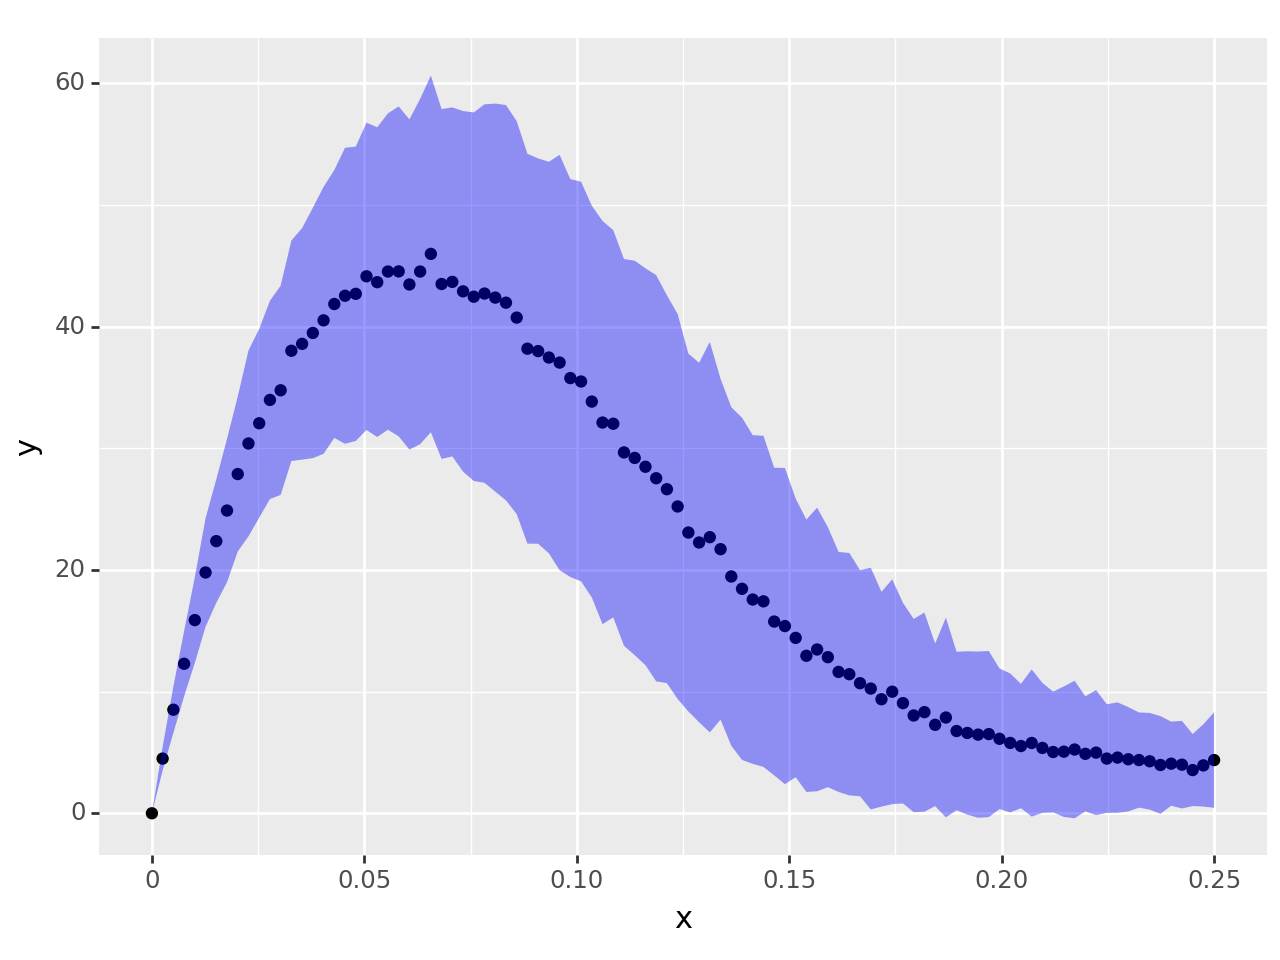

<Figure Size: (640 x 480)>

In [24]:
df = pl.from_records(results, schema=["x", "y", "ymin", "ymax"])


ggplot(df, aes("x", "y", ymin = "ymin", ymax = "ymax")) + geom_point() + geom_ribbon(alpha=0.4, fill="blue")

## Const Esc

100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


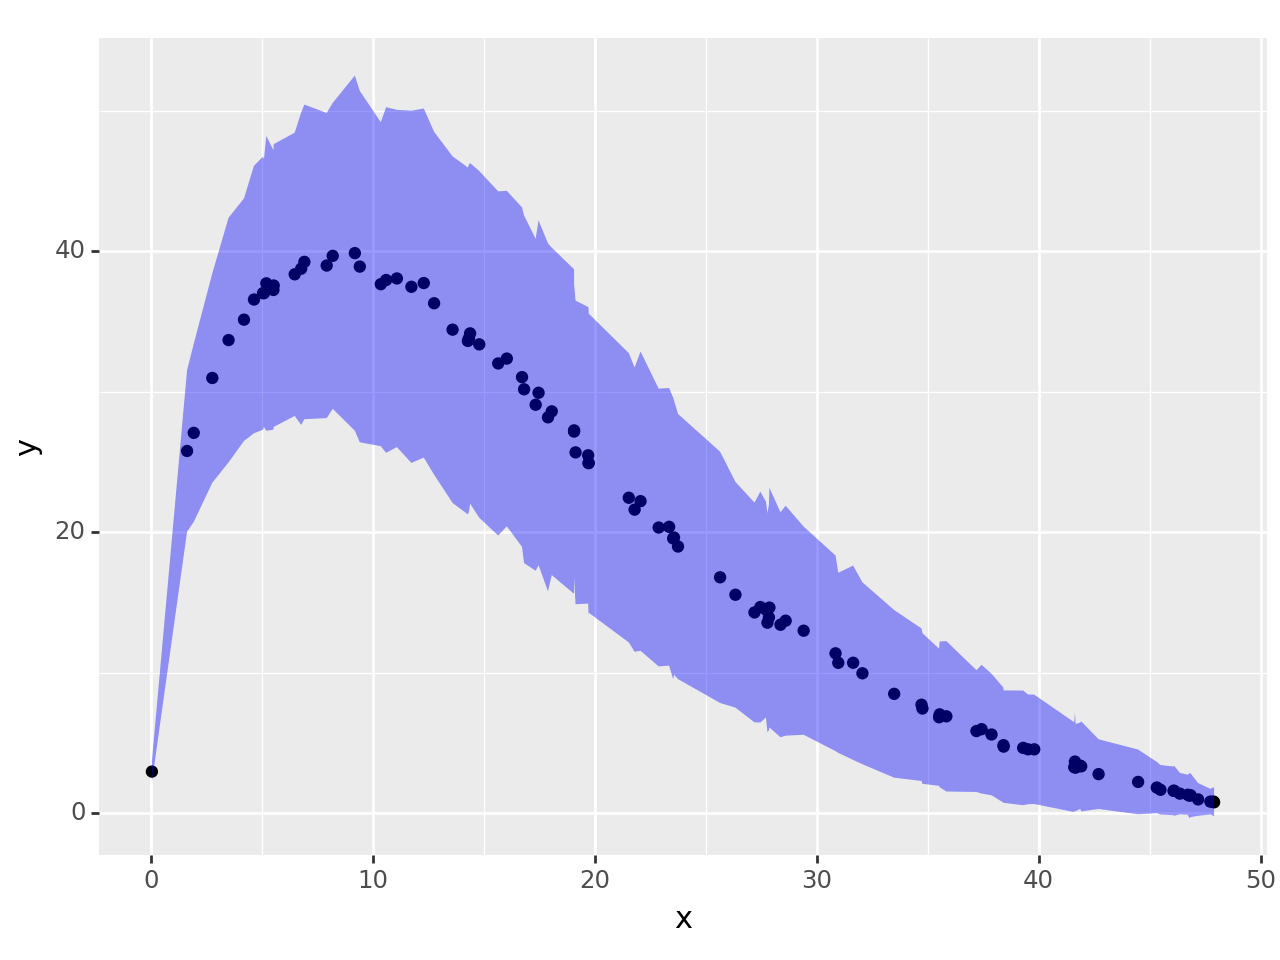

<Figure Size: (640 x 480)>

In [8]:
results = []
for _ in tqdm(range(100)):
    x = np.random.rand() * env.bound
    manager = ConstEsc(escapement=x, obs_bounds=env.bound)
    results.append([x, *gather_stats(manager, env=env)])

df = pl.from_records(results, schema=["x", "y", "ymin", "ymax"])
ggplot(df, aes("x", "y", ymin = "ymin", ymax = "ymax")) + geom_point() + geom_ribbon(alpha=0.4, fill="blue")

In [18]:
env = Asm()
bound=100
manager = ConstEsc(escapement=0.1*bound, obs_bounds=bound)
ray.get([gen_ep_rew.remote(manager, env)])

[5.582908884543385]

In [15]:
manager.predict_raw(np.array([100]))

0.95

In [26]:
cesc_optimum_result = max(results, key= lambda r: r[1])
cesc_optimum_result

[0.17539894531231448, 40.3993942408698, 28.40241125922444, 52.39637722251517]

In [57]:
opt_msy

0.06565656565656566

## Cautionary Rule (MSY-bootstrapped)

In [ ]:
results = []
y2 = opt_msy
for radius in np.linspace(0.001, 0.5, 21):
    print(radius)
    for _ in range(100):
        theta = np.random.rand() * np.pi / 4
        x1 = np.sin(theta) * radius
        x2 = np.cos(theta) * radius 
        # sin / cos are chosen so that x1 < x2
        manager = CautionaryRule(x1=x1, x2=x2, y2=y2)
        
        results.append([x1, x2, *gather_stats(manager, env=env)])

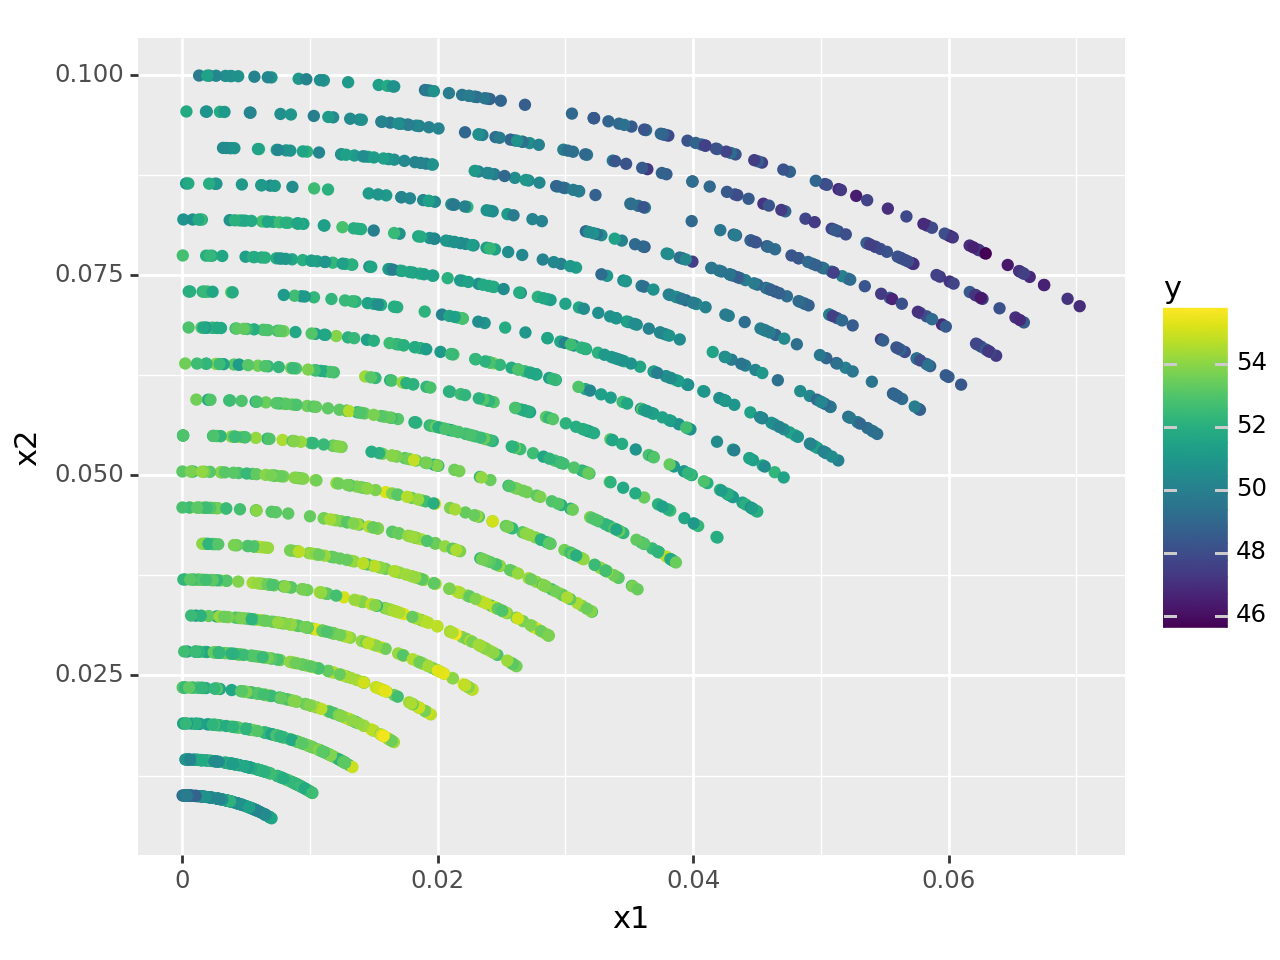

<Figure Size: (640 x 480)>

In [57]:
df = pl.from_records(results, schema=["x1", "x2", "y", "ymin", "ymax"])

from plotnine import ggplot, aes, geom_point

ggplot(df, aes("x1", "x2", color="y")) + geom_point() 

In [63]:
cr_optimum_result = max(results, key= lambda r: r[2])

In [74]:
cesc_optimum_result

[0.200825496640462, 40.16737971515492, 27.523717947684048, 52.8110414826258]

## Gathering best results

In [80]:
optima = {
    "msy" : {
        "opt_arg": msy_optimum_result[0],
        "mean_rew": msy_optimum_result[1],
        "low_rew": msy_optimum_result[2],
        "hi_rew": msy_optimum_result[3],
    },
    "cesc": {
        "opt_arg": cesc_optimum_result[0],
        "mean_rew": cesc_optimum_result[1],
        "low_rew": cesc_optimum_result[2],
        "hi_rew": cesc_optimum_result[3],
    },
    "cr": {
        "opt_arg": f"x1 = {cr_optimum_result[0]}, x2 = {cr_optimum_result[1]}",
        "mean_rew": cr_optimum_result[2],
        "low_rew": cr_optimum_result[3],
        "hi_rew": cr_optimum_result[4],
    }
}
import json

print(json.dumps(optima, indent=2))

{
  "msy": {
    "opt_arg": 0.057281475010678484,
    "mean_rew": 43.431823904527775,
    "low_rew": 29.77316938627395,
    "hi_rew": 57.0904784227816
  },
  "cesc": {
    "opt_arg": 0.200825496640462,
    "mean_rew": 40.16737971515492,
    "low_rew": 27.523717947684048,
    "hi_rew": 52.8110414826258
  },
  "cr": {
    "opt_arg": "x1 = 0.015925028340586737, x2 = 0.02303027295434228",
    "mean_rew": 55.508004457912584,
    "low_rew": 41.701449449441164,
    "hi_rew": 69.314559466384
  }
}


# Using skopt

In [28]:
from skopt import gp_minimize, gbrt_minimize 

## MSY via skopt

In [29]:
def g(x):
    manager = Msy(mortality=x[0])
    out = gather_stats(manager, env)
    return - out[0]

In [30]:
%%time
res = gp_minimize(g, [(0.02, 0.25)], n_calls = 100)
res.x

CPU times: user 2min 22s, sys: 10min 19s, total: 12min 41s
Wall time: 6min 3s


[0.058941150585353846]

In [31]:
%%time
res2 = gbrt_minimize(g, [(0.02, 0.15)], n_calls = 100)
res2.x

/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.


CPU times: user 53.9 s, sys: 8.39 s, total: 1min 2s
Wall time: 5min 34s


[0.05837028956134266]

In [62]:
from skopt.space import Real
from skopt.utils import use_named_args

space  = [Real(0.00001, 1, name='radius'),
          Real(0.00001, np.pi/4.00001, name='theta'),
          Real(0, 0.2, name='y2')]

@use_named_args(space)
def g(**params):

    theta = params["theta"]
    radius = params["radius"]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    
    assert x1 <= x2, ("CautionaryRule error: x1 < x2, " + str(x1) + ", ", str(x2) )

    manager = CautionaryRule(x1 = x1, x2 =  x2, y2 = params["y2"])
    out = gather_stats(manager, env)
    return - out[0]        




CPU times: user 452 µs, sys: 783 µs, total: 1.24 ms
Wall time: 1.24 ms


In [63]:
%%time
res_gp = gp_minimize(g, space, n_calls = 1000)
res_gp.x

[0.05134367336918743, 0.7853961999069485, 0.12335495432997541]

In [ ]:
%%time
res_gbrt = gbrt_minimize(g, space, n_calls = 1000)
res_gbrt.x

In [ ]:

res = res_gbrt
manager = CautionaryRule(x1 = res.x[0], x2 = res.x[1], y2 = res.x[2])
gather_stats(manager, env=env)